In [36]:
import py_wave_runup
from examples.evaluate_returnperiods import load_scenario_data, load_timeseries_data
import sys
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import py_wave_runup
import seaborn as sns


In [55]:
# #Run this if you want to compare different scenarios and return periods
# #=========================================================
# #Wave Dataset
# #=========================================================
Tp_returnvals = pd.read_csv('data\projected_Tp_return_vals.csv')
Tp=np.reshape(Tp_returnvals.drop(columns='return period').values, (15,))
Hs_returnvals = pd.read_csv('data\projected_Hs_return_vals.csv')
Hs=np.reshape(Hs_returnvals.drop(columns='return period').values, (15,))
returnperiod = [5]*3 + [10] * 3 + [20]*3 + [50]*3 + [100]*3
MHHW = 5.24 #ft
setup = 1 #ft


# #=========================================================
# #Slope Info Dataset
# #=========================================================
scenario = 'data\Adamson_M_Z_scenarios.csv'
df = load_scenario_data(scenario, Hs, Tp, returnperiod)

In [4]:
# Run this if you want to run time series
df = load_timeseries_data('data\Hs_ts.csv','data\Tp_ts.csv', dtoe=2, slope=1/10)
MHHW = 5.24 #ft
setup = 1 #ft
df.bsand = 8/10

In [56]:
df_stock = df.copy(deep=True)
df_stock = df_stock.loc[(df_stock.scenario == 1) | (df_stock.scenario==2)]
df = df.loc[(df.scenario==3) | (df.scenario==4)]

blen = py_wave_runup.models.Blenkinsopp2022(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=9.648)
euro = py_wave_runup.models.EurOtop2018(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=9.648)
poate = py_wave_runup.models.Poate2016(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=9.648)
stock = py_wave_runup.models.Stockdon2006(Hs=df_stock.hs,beta=df_stock.beta,bsand=df_stock.bsand,bberm=df_stock.bberm,dtoeSWL=df_stock.dtoeSWL,Tp=df_stock.tp,spectral_wave_period=True,h=9.648)

df_taw = df.copy(deep=True)
df_poate = df.copy(deep=True)

df_stock['r2'] = stock.R2*3.28
df_stock['TWL'] = stock.R2*3.28 + MHHW + setup
df_stock['method'] = ['Sand'] * len(df_stock.hs)


df['r2'] = (blen.R2_eq21)*3.28
df_taw['r2'] = (euro.R2(gamma_f=0.70))*3.28
df_poate['r2'] = (poate.R2())*3.28

df['TWL'] = blen.R2_eq21*3.28 + MHHW + setup
df_taw['TWL'] = (euro.R2(gamma_f=0.70))*3.28 + MHHW + setup
df_poate['TWL'] = (poate.R2())*3.28 + MHHW + setup


df['method'] = ['Cobbles'] * len(df.hs)
df_taw['method'] = ['TAW'] * len(df.hs)
df_poate['method'] = ['Poate 2016'] * len(df.hs)

df_full = pd.concat([df, df_taw, df_poate, df_stock])
df_full['hs'] = df_full['hs']*3.28
df_full['htoe'] = blen.Htoe*3.28

Text(313.14267676767673, 0.5, 'Htoe [ft]')

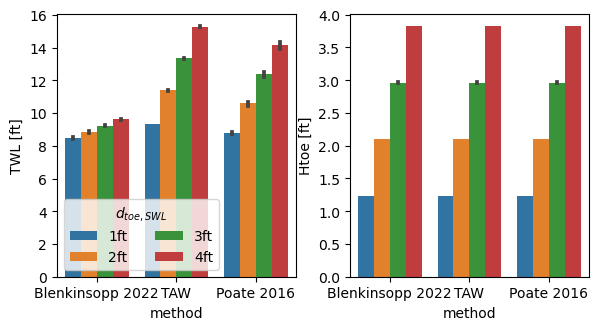

In [13]:
# Run this cell for dtoe plots using dtoescenarios.csv
# i=0
# fig, ax = pl.subplots(1,2)
# pl.tight_layout()
# fig.set_size_inches(6,3)
# a = sns.barplot(x='method',y='TWL', data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==10)&(df_full.dtoeSWL<300)],hue='dtoeSWL',ax=ax[0])
# legend_labels, _= ax[0].get_legend_handles_labels()
# ax[0].legend(legend_labels,['1ft','2ft','3ft','4ft'],title=r'$d_{toe,SWL}$',ncol=2, loc=3)
# ax[0].set_ylabel('TWL [ft]')
# #ax[0].set_xticklabels(df_full.method.unique(),rotation = 45)

# a = sns.barplot(x='method',y='htoe', data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==10)&(df_full.dtoeSWL<300)],hue='dtoeSWL',ax=ax[1])
# ax[1].legend_.remove()
# ax[1].set_ylabel('Htoe [ft]')
# #ax[1].set_xticklabels(df_full.method.unique(),rotation = 45)

    

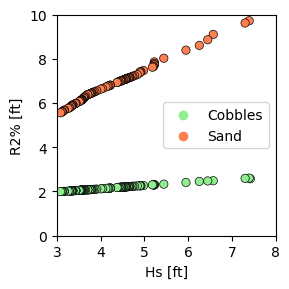

In [32]:
#Run this for continuous data plot
fig, ax = pl.subplots(1,1, figsize=(3,3), tight_layout = {'rect':[0,0,1, 1]})
a = sns.scatterplot(x='hs',y='r2',hue='method',palette=['lightgreen','coral'],data=df_full[(df_full.method=='Cobbles')|(df_full.method=='Sand')],edgecolor='k')
ax.legend(loc='center right')
ax.set_xlabel('Hs [ft]')
ax.set_ylabel('R2% [ft]')
ax.set_xlim((3,8))
ax.set_ylim((0,10))
pl.savefig('hsvsr2vsmethod.png')

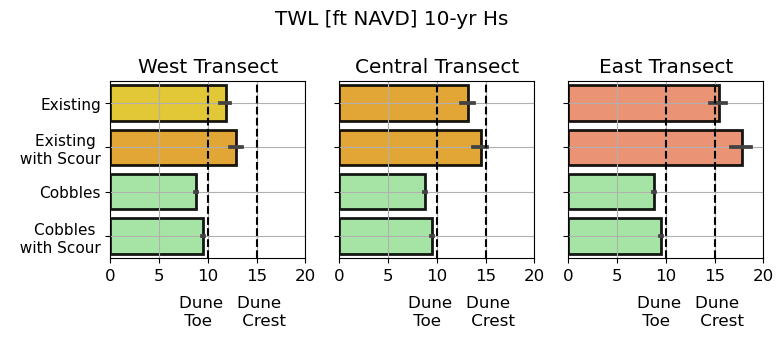

In [65]:
# #Run this for scenario plotting
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
df_full = df_full[(df_full.method =='Sand')|(df_full.method =='Cobbles')]
rp =10
kwargs = {'alpha':0.9, 'linewidth':2, 'edgecolor':'k'}
tranlocs = ['West', 'Central', 'East']
barcolors = [['gold','orange','lightgreen','lightgreen'],['orange','orange','lightgreen','lightgreen'],['coral','coral','lightgreen','lightgreen']]
fig, ax = pl.subplots(1,3,figsize=(8,3.5), tight_layout = {'rect':[0,0,1, 1]})
for i in range(3):
    a = sns.barplot(y='scenario',x='TWL',orient='h', data=df_full[(df_full.transect==3-i)&(df_full.returnperiod==rp)],ax = ax[i], palette = barcolors[i], **kwargs)
#     plotlegend = False
#     if (i==0):
#         plotlegend=True
#     if plotlegend:
#         ax[i].legend(bbox_to_anchor=(1.1,0.8))
#     if not plotlegend:
#         a.legend_.remove()
    ax[i].set_title('{0} Transect'.format(tranlocs[i]))
    ax[i].set_xticks([0,5,10,15,20])
    ax[i].set_xticklabels(['0', '5','10','15','20'])
    ax[i].grid()
    ax[i].set_xlabel('')
    ax[i].set_xlim((0,20))
    ax[i].set_ylabel('')
    ax[i].axvline(10,linestyle = '--', color = 'k')
    ax[i].axvline(15,linestyle = '--', color = 'k')
    ax[i].text(7, 5, 'Dune \n Toe')
    ax[i].text(13, 5, 'Dune \n Crest')
    if i > 0:
        ax[i].set_yticklabels('')

    if i == 0:
        ax[i].set_yticklabels(['Existing', 'Existing \n with Scour', 'Cobbles', 'Cobbles \n  with Scour'], fontsize=11)
pl.suptitle('TWL [ft NAVD] 10-yr Hs')
pl.savefig('scenarios.png')


     transect   beta     bsand   dtoeSWL  bberm  scenario        hs  \
108       1.0  999.0  0.084961  0.909091   0.14       4.0  7.888905   
109       1.0  999.0  0.084961  0.909091   0.14       4.0  7.026650   
110       1.0  999.0  0.084961  0.909091   0.14       4.0  8.773649   
138       2.0  999.0  0.055862  0.909091   0.14       4.0  7.888905   
139       2.0  999.0  0.055862  0.909091   0.14       4.0  7.026650   
140       2.0  999.0  0.055862  0.909091   0.14       4.0  8.773649   
168       3.0  999.0  0.040000  0.909091   0.14       4.0  7.888905   
169       3.0  999.0  0.040000  0.909091   0.14       4.0  7.026650   
170       3.0  999.0  0.040000  0.909091   0.14       4.0  8.773649   

            tp  returnperiod        r2       TWL   method      htoe  
108  23.952039          10.0  3.260987  9.500987  Cobbles  2.965676  
109  22.220000          10.0  3.173409  9.413409  Cobbles  2.963096  
110  24.362886          10.0  3.377102  9.617102  Cobbles  2.969096  
138  23.9

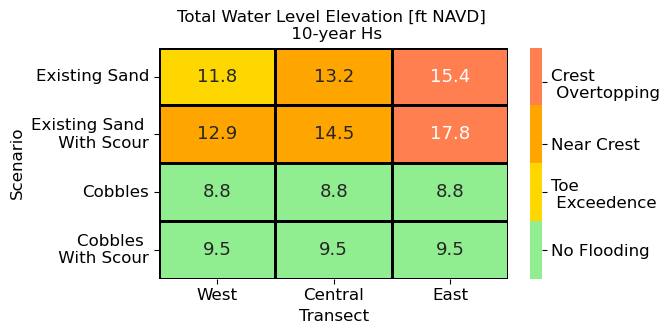

In [64]:
#Plot only Blenkinsopp and Stockdon
df_full = df_full[(df_full.method =='Sand')|(df_full.method =='Cobbles')]
df_full = df_full[(df_full.returnperiod==10)]
print(df_full[df_full.scenario==4])
vals = df_full.pivot_table(columns = 'transect',index='scenario',values = 'TWL')
cmap = mpl.colors.ListedColormap(["lightgreen", "gold",'orange',"coral"])
norm = mpl.colors.BoundaryNorm([8,10,12,15,20], cmap.N) 
vals = vals.reindex([3,2,1], axis=1)

#make font size bigger
#include grid lines 
fig, ax = pl.subplots(1,1,figsize=(7,3.5), tight_layout = {'rect':[0,0,0.98, 1]})
aa=sns.heatmap(vals, annot=True, fmt=".1f",annot_kws={"size": 13}, vmin=15,vmax=25,cmap=cmap,norm=norm,linewidths=2,linecolor='k')
ax.set_ylabel('Scenario',fontsize=12)
ax.set_yticklabels(['Existing Sand', 'Existing Sand \n With Scour', 'Cobbles', 'Cobbles \n With Scour'], rotation = 0)
ax.set_xlabel('Transect',fontsize=12)
ax.set_xticklabels(['West', 'Central','East']) #Transect 1 is east, 2 is central, 3 is west
#ax.xaxis.tick_top() # x axis on top
#ax.xaxis.set_label_position('top')
ax.set_title('Total Water Level Elevation [ft NAVD] \n 10-year Hs', fontsize=12)# put label on bottom
cbar = aa.collections[0].colorbar
cbar.set_ticks([9,11,13,17])
cbar.set_ticklabels(['No Flooding', 'Toe \n Exceedence', 'Near Crest', 'Crest \n Overtopping'], fontsize=12)
pl.savefig('ComparativeMatrix.png',dpi=100)





[67.80784377220917, 70.10086425075299, 57.30438009045792, 58.16094071056253, 46.355976447580446, 47.985622616158196]


<AxesSubplot:xlabel='Scenario', ylabel='Percent Reduction'>

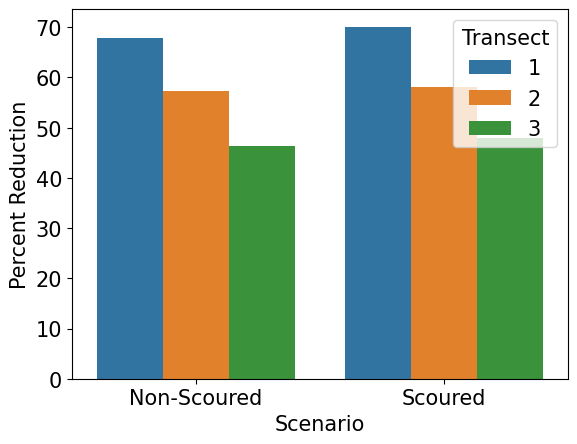

In [34]:
#Percent reduction charts
transect = []
plesslist = []
scenario = []

for i in range(1,4):
    r2_old = df_full[(df_full.method=='Stockdon')&(df_full.scenario==1)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    r2_new = df_full[(df_full.method=='Blenkinsopp 2022')&(df_full.scenario==3)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    pless = (r2_old-r2_new)/r2_old*100
    plesslist.append(pless)
    scenario.append('Non-Scoured')
    transect.append(i)
    
    r2_old = df_full[(df_full.method=='Stockdon')&(df_full.scenario==2)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    r2_new = df_full[(df_full.method=='Blenkinsopp 2022')&(df_full.scenario==4)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    pless_scour = (r2_old-r2_new)/r2_old*100
    plesslist.append(pless_scour)
    scenario.append('Scoured')
    transect.append(i)

percent_reduct_df = pd.DataFrame({'Transect':transect, 'Percent Reduction':plesslist, 'Scenario':scenario})

print(plesslist)

fig, ax = pl.subplots(1,1)
sns.barplot(y='Percent Reduction',x='Scenario',hue='Transect',data=percent_reduct_df)
